Filtered dataset saved to: data/clustering_input_final.csv
PCA reduced feature dimensions from 10 to 3
Silhouette Score for 5 clusters: 0.2442
K-Means clustering with Cosine Similarity completed. 5 clusters assigned and saved to data/kmeans_cosine_clustering_results_5_1-1_threshold_0.3.csv!


C:\Users\nicar\AppData\Local\Temp\ipykernel_27972\3955144721.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pivot = df_pivot.applymap(reweight_correlations)


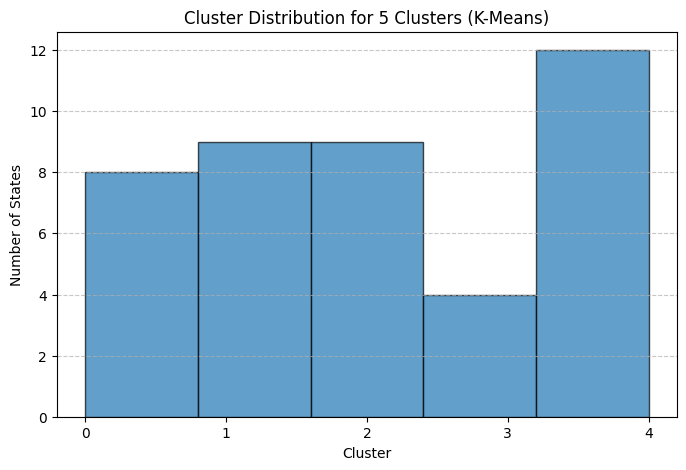

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Load the Updated Correlation Trends Data ---
file_path = "data/notable_state_correlation_trends_filtered.csv"
df = pd.read_csv(file_path)

# --- Step 2: Thresholding: Keep Only Correlations ≥ |0.25| ---
df_filtered = df[(df['Correlation'] >= 0.3) | (df['Correlation'] <= -0.3)]

# --- Save Filtered Data Before Clustering ---
filtered_output_path = "data/clustering_input_final.csv"
df_filtered.to_csv(filtered_output_path, index=False)
print(f"Filtered dataset saved to: {filtered_output_path}")

# --- Step 3: Pivot Data: Transform for Clustering ---
df_pivot = df_filtered.pivot(index='State', columns=['Metric 1', 'Metric 2'], values='Correlation').fillna(0)

# --- Step 4: Re-weight Strong Correlations ---
def reweight_correlations(x):
    """ Apply a weight to emphasize strong correlations (above ±0.5). """
    return x * (1.1 if abs(x) >= 0.5 else 1.0)

df_pivot = df_pivot.applymap(reweight_correlations)

# Convert to numpy array for clustering
X = df_pivot.to_numpy()

# --- Step 5: Standardize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 6: Apply PCA (Optional) ---
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced feature dimensions from {X.shape[1]} to {X_pca.shape[1]}")

# --- Step 7: Compute Cosine Similarity Matrix ---
cosine_sim = cosine_similarity(X_pca)

# --- Step 8: Run K-Means Clustering ---
n_clusters = 5  # Manually set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(cosine_sim)

# --- Step 9: Compute Silhouette Score ---
silhouette = silhouette_score(X_pca, labels)
print(f"Silhouette Score for {n_clusters} clusters: {silhouette:.4f}")

# --- Step 10: Save Clustering Results ---
df_pivot['Cluster'] = labels
df_pivot.reset_index(inplace=True)
clustering_output_path = f"data/kmeans_cosine_clustering_results_{n_clusters}_1-1_threshold_0.3.csv"
df_pivot[['State', 'Cluster']].to_csv(clustering_output_path, index=False)

print(f"K-Means clustering with Cosine Similarity completed. {n_clusters} clusters assigned and saved to {clustering_output_path}!")

# --- Step 11: Plot Cluster Distribution ---
plt.figure(figsize=(8, 5))
plt.hist(labels, bins=n_clusters, edgecolor='black', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Number of States")
plt.title(f"Cluster Distribution for {n_clusters} Clusters (K-Means)")
plt.xticks(range(n_clusters))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [2]:
# --- Identify Missing States at Each Stage ---
print("\nChecking for missing states during clustering...")

# Load original cleaned dataset
df_cleaned = pd.read_csv("data/cleaned_multiple_cause_of_death.csv")
original_states = set(df_cleaned["State"].unique())

# Load states after correlation filtering
df_corr_filtered = pd.read_csv("data/notable_state_correlation_trends_filtered.csv")
correlation_states = set(df_corr_filtered["State"].unique())

# Load states from final clustering results
df_clustered = pd.read_csv("data/weighted_clustering_results.csv")
clustered_states = set(df_clustered["State"].unique())

# Identify missing states at each stage
missing_after_correlation = original_states - correlation_states
missing_after_clustering = correlation_states - clustered_states

# Print missing states at each stage
if missing_after_correlation:
    print("States missing after correlation filtering:")
    print(", ".join(sorted(missing_after_correlation)))
else:
    print("No states were lost after correlation filtering.")

if missing_after_clustering:
    print("States missing after clustering:")
    print(", ".join(sorted(missing_after_clustering)))
else:
    print("No states were lost after clustering.")

print("\nClustering process completed successfully!")



Checking for missing states during clustering...
States missing after correlation filtering:
North Dakota
No states were lost after clustering.

Clustering process completed successfully!
